# Exploratory Analysis

* $RQ_1$: How does temporal proximity affect sharing behaviour during protest demonstrations?
* $RQ_2$: How do source attributes like the poster's gender affect sharing behaviour during protest demonstrations?
* $RQ_3$: Is there evidence of a "backfire effect" where misleading posts that *don't* have a credibility indicator are assumed to be true and more likely to be reshared.
* $RQ_4$: Does the treatment effectiveness vary by political affiliation?

In [2]:
library(lme4)
library(AER)
library(dplyr)
library(purrr)
library(magrittr)
library(ggplot2)
require(ggiraph)
require(plyr)
require(moonBook)   # for use of data radial
require(GGally)
require(reshape2)
require(compiler)
require(parallel)
require(boot)
require(lattice)

data <- read.csv("../../data/processed/60b37265a9f60881975de69e-rumour-results.csv")
data$reshared <- as.integer(as.logical(data$reshared))
head(data)

Loading required package: moonBook

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘moonBook’”


,user_id,condition,timeSubmitted,secondsTaken,id,rumour,code,evidence,warning,reshared,clickedWarning,timestamp,posterGender,posterId
,<dbl>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
1,5.842738e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283849e+18,R1,neutral,high,False,0,False,3,male,RnJlZGVyaWNrIFdvb2RodHRwczovL3JhbmRvbXVzZXIubWUvYXBpL3BvcnRyYWl0cy90aHVtYi9tZW4vMTkuanBn
2,5.842738e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283767e+18,R1,neutral,high,False,0,False,4,female,S2F0aWUgTXVycGh5aHR0cHM6Ly9yYW5kb211c2VyLm1lL2FwaS9wb3J0cmFpdHMvdGh1bWIvd29tZW4vNjQuanBn
3,5.842738e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283508e+18,R1,denies,high,True,0,False,11,male,R2FyeSBIb3BraW5zaHR0cHM6Ly9yYW5kb211c2VyLm1lL2FwaS9wb3J0cmFpdHMvdGh1bWIvbWVuLzc4LmpwZw==
4,5.842738e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283371e+18,R1,affirms,high,False,0,False,11,female,V2lsbGllIENsYXJraHR0cHM6Ly9yYW5kb211c2VyLm1lL2FwaS9wb3J0cmFpdHMvdGh1bWIvd29tZW4vNy5qcGc=
5,5.842738e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283538e+18,R1,affirms,high,False,1,False,13,female,TWVsaW5kYSBCYXJyZXR0aHR0cHM6Ly9yYW5kb211c2VyLm1lL2FwaS9wb3J0cmFpdHMvdGh1bWIvd29tZW4vNjIuanBn
6,5.842738e+18,treatment,2021-06-03 09:50:15.953000+00:00,120,1.283492e+18,R1,questions,high,False,1,False,14,male,TG9ubmllIE1pbGVzaHR0cHM6Ly9yYW5kb211c2VyLm1lL2FwaS9wb3J0cmFpdHMvdGh1bWIvbWVuLzEwLmpwZw==


### Logistic regression

Alt add an interaction between warning and evidence (if we expect there to be different effects for putting a cred indicator on a post denying a high evidence rumour vs affirming a low evidence rumour.

* $RQ_1$: How does temporal proximity affect sharing behaviour during protest demonstrations?
* $RQ_2$: How do source attributes like the poster's gender affect sharing behaviour during protest demonstrations?

In [3]:
md <- glmer(reshared ~ posterGender + timestamp + warning + code * evidence + (condition | user_id) + (1 | posterId) + (1 | id),
            data = data,
            family = binomial, 
            control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5))
           )
summary(md)

boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: reshared ~ posterGender + timestamp + warning + code * evidence +  
    (condition | user_id) + (1 | posterId) + (1 | id)
   Data: data
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  3772.3   3877.7  -1870.2   3740.3     5332 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0022 -0.3853 -0.2318 -0.1227  9.7530 

Random effects:
 Groups   Name               Variance Std.Dev. Corr 
 posterId (Intercept)        0.0000   0.0000        
 id       (Intercept)        0.6876   0.8292        
 user_id  (Intercept)        1.4746   1.2143        
          conditiontreatment 0.6054   0.7781   -0.35
Number of obs: 5348, groups:  posterId, 5347; id, 167; user_id, 97

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -1

### $RQ_4$

In [4]:
library(lme4)

reshare_rates <- read.csv("../../data/processed/60b37265a9f60881975de69e-reshare_rates.csv")
md.affirms <- lmer(Affirms ~ politicalAffiliation * condition * evidence + (1 | user_id), data = reshare_rates)
summary(md.affirms)


Correlation matrix not shown by default, as p = 24 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML ['lmerMod']
Formula: Affirms ~ politicalAffiliation * condition * evidence + (1 |  
    user_id)
   Data: reshare_rates

REML criterion at convergence: -117.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7758 -0.4238 -0.1529  0.3705  2.5242 

Random effects:
 Groups   Name        Variance Std.Dev.
 user_id  (Intercept) 0.01402  0.1184  
 Residual             0.01153  0.1074  
Number of obs: 182, groups:  user_id, 91

Fixed effects:
                                                               Estimate
(Intercept)                                                     0.04000
politicalAffiliationcentreLeft                                  0.07818
politicalAffiliationcentreRight                                 0.14333
politicalAffiliationleft                                        0.10000
politicalAffiliationnone                                        0.18000
politicalAffiliationright                                      -0.04000
conditionT

In [5]:
coefs <- data.frame(coef(summary(md.affirms)))
# get Satterthwaite-approximated degrees of freedom
coefs$df.Satt <- coef(summary(md.affirms))
# get approximate p-values
coefs$p.Satt <- coef(summary(md.affirms))[, 2]
coefs

,Estimate,Std..Error,t.value,df.Satt,p.Satt
,<dbl>,<dbl>,<dbl>,"<dbl[,3]>",<dbl>
(Intercept),0.04000000,0.07148557,0.5595535,"0.04000000, 0.07148557, 0.5595535",0.07148557
politicalAffiliationcentreLeft,0.07818182,0.07919339,0.9872265,"0.07818182, 0.07919339, 0.9872265",0.07919339
politicalAffiliationcentreRight,0.14333333,0.09679193,1.4808398,"0.14333333, 0.09679193, 1.4808398",0.09679193
politicalAffiliationleft,0.10000000,0.08254443,1.2114688,"0.10000000, 0.08254443, 1.2114688",0.08254443
politicalAffiliationnone,0.18000000,0.10109587,1.7804882,"0.18000000, 0.10109587, 1.7804882",0.10109587
politicalAffiliationright,-0.04000000,0.17510318,-0.2284367,"-0.04000000, 0.17510318, -0.2284367",0.17510318
conditionTreatment,0.17250000,0.09112659,1.8929712,"0.17250000, 0.09112659, 1.8929712",0.09112659
evidenceLow,0.02000000,0.06790304,0.2945376,"0.02000000, 0.06790304, 0.2945376",0.06790304
politicalAffiliationcentreLeft:conditionTreatment,-0.20179293,0.11092544,-1.8191762,"-0.20179293, 0.11092544, -1.8191762",0.11092544


Loading required package: carData

lattice theme set by effectsTheme()
See ?effectsTheme for details.



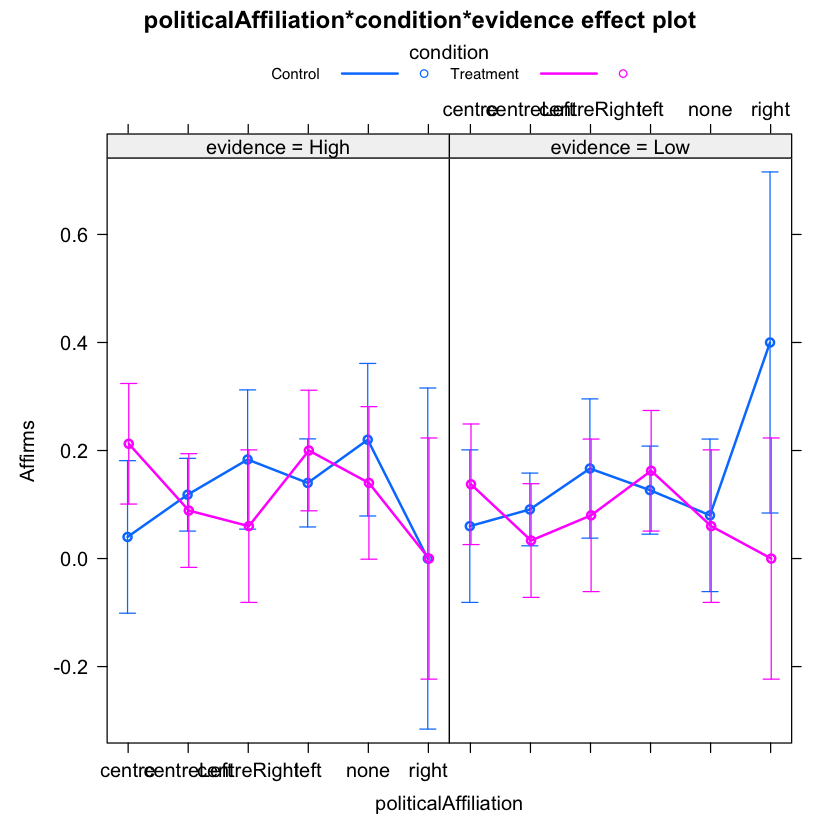

In [8]:
library(effects)
plot(allEffects(md.affirms), multiline=TRUE, ci.style="bars")

In [6]:
md.denies <- lmer(Denies ~ politicalAffiliation * condition * evidence + (1 | user_id), data = reshare_rates)
summary(md.denies)


Correlation matrix not shown by default, as p = 24 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML ['lmerMod']
Formula: Denies ~ politicalAffiliation * condition * evidence + (1 | user_id)
   Data: reshare_rates

REML criterion at convergence: -60

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1008 -0.5107 -0.1438  0.3853  3.7136 

Random effects:
 Groups   Name        Variance Std.Dev.
 user_id  (Intercept) 0.002906 0.05391 
 Residual             0.027893 0.16701 
Number of obs: 182, groups:  user_id, 91

Fixed effects:
                                                                Estimate
(Intercept)                                                     0.060000
politicalAffiliationcentreLeft                                  0.003636
politicalAffiliationcentreRight                                 0.040000
politicalAffiliationleft                                       -0.020000
politicalAffiliationnone                                        0.080000
politicalAffiliationright                                      -0.060000
conditionTrea

In [7]:
coefs <- data.frame(coef(summary(md.denies)))
# get Satterthwaite-approximated degrees of freedom
coefs$df.Satt <- coef(summary(md.denies))
# get approximate p-values
coefs$p.Satt <- coef(summary(md.denies))[, 2]
coefs

,Estimate,Std..Error,t.value,df.Satt,p.Satt
,<dbl>,<dbl>,<dbl>,"<dbl[,3]>",<dbl>
(Intercept),0.060000000,0.07848460,0.76448118,"0.060000000, 0.07848460, 0.76448118",0.07848460
politicalAffiliationcentreLeft,0.003636364,0.08694708,0.04182272,"0.003636364, 0.08694708, 0.04182272",0.08694708
politicalAffiliationcentreRight,0.040000000,0.10626865,0.37640451,"0.040000000, 0.10626865, 0.37640451",0.10626865
politicalAffiliationleft,-0.020000000,0.09062621,-0.22068671,"-0.020000000, 0.09062621, -0.22068671",0.09062621
politicalAffiliationnone,0.080000000,0.11099399,0.72075977,"0.080000000, 0.11099399, 0.72075977",0.11099399
politicalAffiliationright,-0.060000000,0.19224722,-0.31209814,"-0.060000000, 0.19224722, -0.31209814",0.19224722
conditionTreatment,-0.022500000,0.10004863,-0.22489064,"-0.022500000, 0.10004863, -0.22489064",0.10004863
evidenceLow,0.020000000,0.10562810,0.18934356,"0.020000000, 0.10562810, 0.18934356",0.10562810
politicalAffiliationcentreLeft:conditionTreatment,0.036641414,0.12178596,0.30086732,"0.036641414, 0.12178596, 0.30086732",0.12178596


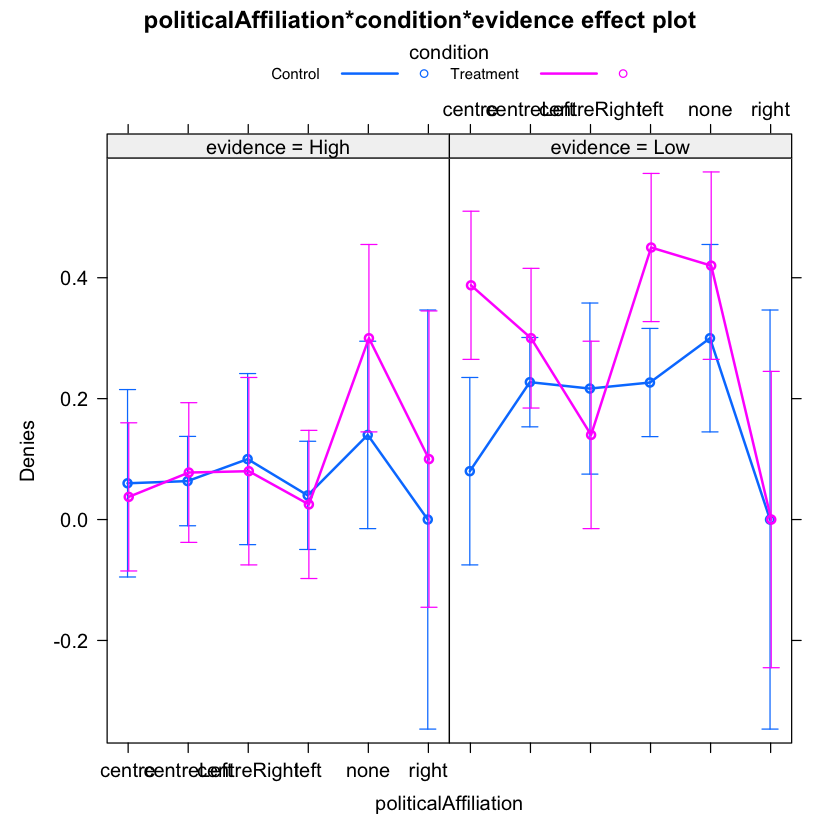

In [9]:
plot(allEffects(md.denies), multiline=TRUE, ci.style="bars")